# Contact Prediction

## Dependencies

In [1]:
# ! pip install amplify scikit-learn

In [2]:
import os
import numpy as np
import pandas as pd
from itertools import product

import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from utils import load_pickle_dataset, load_from_hf, load_from_mila, apc, symmetrize

[2024-09-04 08:11:31,552] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


## Arguments 

In [3]:
# Model
source = "mila"
model_name = "AMPLIFY350M"
model_path = "../outputs/checkpoints/MILA_PLM_350M_UR100P_ex/checkpoints/checkpoint_1050/pytorch_model.pt"
tokenizer_path = None 
config_path = "../outputs/checkpoints/MILA_PLM_350M_UR100P_ex/checkpoints/checkpoint_1050/config.yaml"
device = "cuda"
compile = False
fp16 = True

# Dataset
data_name = "CASP14"
data_path = "../uniref/mila/casp14.pickle"
n_proteins = 25
max_length = 1024

# Logistic Regression
n_train_samples = 20
thershold_c_alpha = 8
min_sep = 6
l1_penalty = 0.15
seed = 0
    
# Log
output_file = "../outputs/AMPLIFY_Contact_CASP14.csv"

## Prediction

In [4]:
# Load dataset
labels, proteins, dist_matrices = load_pickle_dataset(data_path, n_proteins, max_length)

# Random split
labels_train, labels_test, proteins_train, proteins_test, dist_matrices_train, dist_matrices_test = train_test_split(labels, proteins, dist_matrices, train_size=n_train_samples, random_state=seed)

# Compute contacts maps from distance matrices
contact_maps_train = list(map(lambda x: x < thershold_c_alpha, dist_matrices_train))
contact_maps_test = list(map(lambda x: x < thershold_c_alpha, dist_matrices_test))

Skipped T1033_6vr4_A because sequence length is longer than 1022
Skipped T1033_6vr4_B because sequence length is longer than 1022
Skipped T1035_6vr4_A because sequence length is longer than 1022
Skipped T1035_6vr4_B because sequence length is longer than 1022


In [5]:
# Get model and tokenizer
if source == "hf":
    model, tokenizer = load_from_hf(model_path, tokenizer_path, fp16=fp16)
elif source == "mila":
    model, tokenizer = load_from_mila(model_path, config_path)
else:
    raise Exception("Only 'hf' and 'mila' sources are supported, not {source}.")
model.to(device)
torch.compile(model, disable=~compile)

AMPLIFY(
  (encoder): Embedding(27, 960, padding_idx=0)
  (transformer_encoder): ModuleList(
    (0-31): 32 x EncoderBlock(
      (q): Linear(in_features=960, out_features=960, bias=False)
      (k): Linear(in_features=960, out_features=960, bias=False)
      (v): Linear(in_features=960, out_features=960, bias=False)
      (wo): Linear(in_features=960, out_features=960, bias=False)
      (resid_dropout): Dropout(p=0, inplace=False)
      (ffn): SwiGLU(
        (w12): Linear(in_features=960, out_features=5120, bias=False)
        (w3): Linear(in_features=2560, out_features=960, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (ffn_dropout): Dropout(p=0, inplace=False)
    )
  )
  (layer_norm_2): RMSNorm()
  (decoder): Linear(in_features=960, out_features=27, bias=True)
)

In [6]:
def get_attn_map(model, tokenizer, protein, device, fp16):
    with torch.no_grad(), torch.autocast(device_type=device, dtype=torch.float16, enabled=fp16):
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        x = torch.as_tensor(tokenizer.encode(protein)).to(torch.long)  # tokenize the protein
        x = x.unsqueeze(0).to(device)
        attn_map = model(x, output_attentions=True)["attentions"]
        attn_map = torch.stack(attn_map).detach().cpu()  # stack the attention maps and move to CPU
        attn_map = attn_map.reshape(-1, x.size(-1), x.size(-1))  # (map, residues, residues)
        attn_map = attn_map[:, 1:-1, 1:-1]  # remove special tokens <bos> and <eos>
        attn_map = apc(symmetrize(attn_map))  # process the attention maps
        attn_map = attn_map.permute(1, 2, 0)  # (residues, residues, map)
        return attn_map

In [7]:
# Adapted from https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: torch.Tensor = None,
    minsep: int = 6,
    maxsep: int = None,
    override_length: int = None,
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(gather_lengths, device=device)

    gather_indices = (torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(binned_cumulative_dist)

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}

def evaluate_prediction(predictions: torch.Tensor, targets: torch.Tensor):
    contact_ranges = [("local", 3, 6), ("short", 6, 12), ("medium", 12, 24), ("long", 24, None)]
    metrics = {}
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(predictions, targets, minsep=minsep, maxsep=maxsep)
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [8]:
# Adapted from https://github.com/facebookresearch/esm/blob/main/examples/contact_prediction.ipynb
def plot_contacts_and_predictions(predictions, contacts, ax, cmap="Blues", ms=1, title_text=True) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    img = ax.imshow(masked_image, cmap=cmap)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

In [9]:
# Create a lower diagonal mask with an offset of min_sep_eval and flatten
X_train, y_train = list(), list()
for protein, contact_map in zip(proteins_train, contact_maps_train):
    pos = np.arange(contact_map.shape[0])
    attn_map = get_attn_map(model, tokenizer, protein, device, fp16)
    diag_idx = np.expand_dims(pos, axis=0) - np.expand_dims(pos, axis=1) >= min_sep
    X_train.extend(attn_map[diag_idx, :].reshape(-1, attn_map.shape[-1]).to(torch.float32))
    y_train.extend(contact_map[diag_idx].reshape(-1))
X_train = np.asarray(X_train, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)

# Logistic Regression (careful, liblinear does not support int64!)
clf = LogisticRegression(solver="liblinear", penalty="l1", C=l1_penalty)
clf.fit(X_train, y_train)

LogisticRegression(C=0.15, penalty='l1', solver='liblinear')

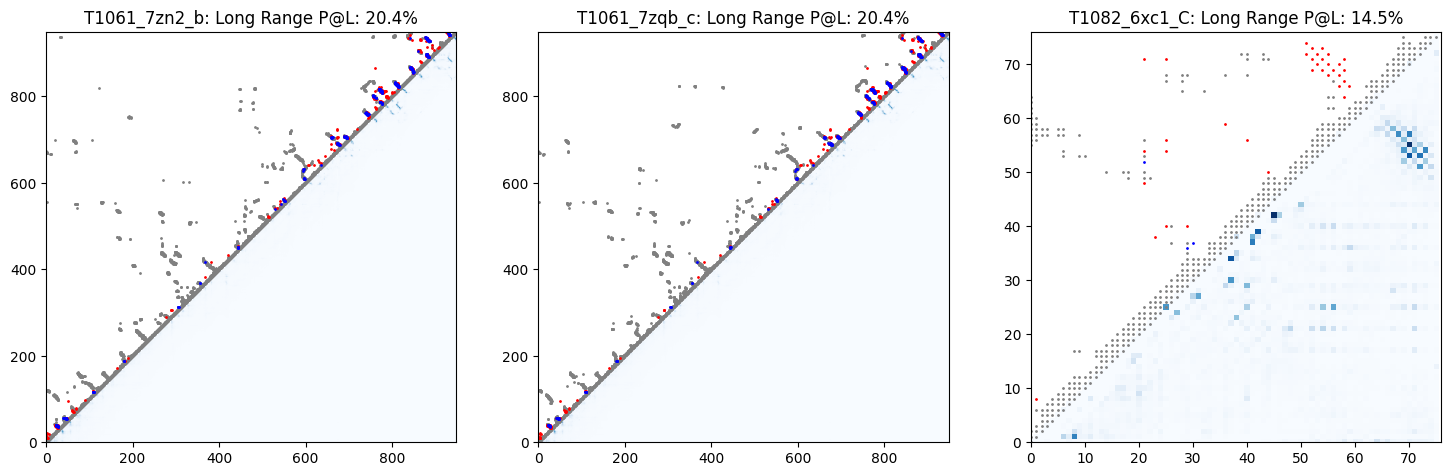

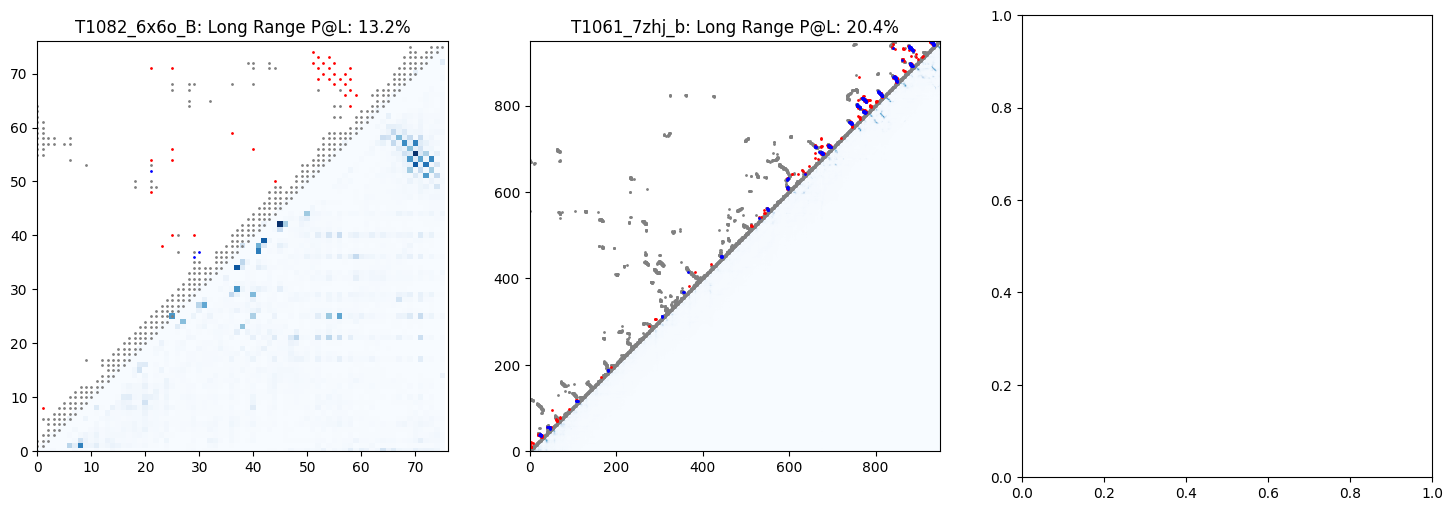

In [10]:
# Predict and evaluate
for i, (label, protein, y_true) in enumerate(zip(labels_test, proteins_test, contact_maps_test)):
    x = get_attn_map(model, tokenizer, protein, device, fp16)
    y_pred = clf.predict_proba(x.reshape(-1, x.shape[-1]))[:, 1].reshape(y_true.shape)
    
    scores = evaluate_prediction(y_pred, y_true)
        
    # Visualize
    if i % 3 == 0:
        fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
    
    plot_contacts_and_predictions(y_pred,
                                  y_true,
                                  ax=axes[i%3],
                                  title_text=f"{label}: Long Range P@L: {scores['long_P@L']:0.1%}",
                                  )

    if i % 3 == 2:
        plt.show()
        plt.close()
        
plt.show()
plt.close()